# Manual ingest workflow, bypassing GUI

## Login

Either log in via a local config file (see [01_pipeline](./01_pipeline.ipynb)), or enter login information manually. If you are don't have your login information, contact the administrator.


In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
from adamacs.pipeline import subject, session, equipment, surgery, event, trial, imaging, behavior, model
from adamacs.ingest import session as isess
from adamacs.ingest import behavior as ibe
import pathlib
from natsort import natsorted, ns
import datajoint as dj
from rspace_client.eln import eln
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib.metadata import version
dj.__version__

[2023-12-04 15:06:04,075][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-12-04 15:06:04,121][INFO]: Connected tobiasr@172.26.128.53:3306


'0.14.1'

### RSpace connection

In [2]:
URL=dj.config['custom'].get('rspace_URL')
API_KEY=dj.config['custom'].get('rspace_API_key')
api = eln.ELNClient(URL, API_KEY)
print(api.get_status())
version('rspace_client')


{'message': 'OK', 'rspaceVersion': '1.93.0'}


'2.5.0'

In [3]:
# ### get names and IDs of animal follders in the "Experiments" Rspace directory
# folders = api.list_folder_tree()
# experiments_ids = []
# for record in folders['records']:
#     if record['name'] == 'Experiments':
#         experiments_ids.append(record['id'])
# # print(folders)
# names_and_ids = []
# subfolders = api.list_folder_tree(experiments_ids[0])
# names_and_ids.append([(record['name'], record['id']) for record in subfolders['records']])
# print(names_and_ids)

In [4]:

# api.create_folder(name=f"test", parent_folder_id=23795, notebook=True)


In [5]:
# new_doc = api.create_document(name=f"test3", parent_folder_id=experiments_ids[0])

In [6]:
# userID = "XX"
# animalID = "YY"

# new_folder = api.create_folder(name=f"{userID}_{animalID}", parent_folder_id=experiments_ids[0], notebook=True)
# save_folder_id = new_folder['id']

## Activation
Next, import from `adamacs.pipeline` to activate the relevant schema.

In [7]:
from adamacs.utility import *
# from adamacs.nbgui import *
from adamacs.pipeline import subject, session, surgery, scan, equipment, model

Assign easy names for relevant tables

In [8]:
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath()
    )

some helpers

In [9]:
from adamacs.helpers import dj_helpers as djh
from adamacs.helpers import stack_helpers as sh

## Parse directories

In [10]:
# get content of user directory
import fnmatch
dataroot = dj.config['custom']['exp_root_data_dir'][0]
# dirs_root = [d for d in os.listdir(dataroot) if os.path.isdir(os.path.join(dataroot, d)) and '_' in d]
dirs_root = [d for d in os.listdir(dataroot) if os.path.isdir(os.path.join(dataroot, d)) and fnmatch.fnmatch(d, '*NK*') and fnmatch.fnmatch(d, '*10*')]
sorted_dirs_root = natsorted(dirs_root, key=djh.get_date_key_from_dir, reverse = True)
sorted_dirs_root

['NK_ROS-1629_2023-10-20_scan9FKOE4N6_sess9FKOE4N6',
 'NK_ROS-1629_2023-10-20_scan9FKOI7ZY_sess9FKOI7ZY',
 'NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y',
 'NK_ROS-1629_2023-10-18_scan9FKNDBWA_sess9FKNDBWA',
 'NK_ROS-1629_2023-10-13_scan9FKKC1QB_sess9FKKC1QB',
 'NK_ROS-1629_2023-10-11_scan9FKJ0TLI_sess9FKJ0TLI',
 'NK_ROS-1629_2023-10-10_scan9FKII73H_sess9FKII73H',
 'NK_ROS-1576_2023-07-10_scan9FIZNWNS_sess9FIZNWNS']

In [11]:
sessi = "sess9FKNRW9Y"
scansi = "scan9FKNRW9Y"
# sessi = "sess9FK61CPU"
# scansi = "scan9FK61CPU"

# sessi = "sess9FKSMYYS"
# scansi = "scan9FKSMYYS"

# scan9FJ842C3
# scan9FB2LN5C
# scan_key      

# scansi = "scan9FKSMYYS"

# scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
# curation_key = (imaging.Curation & scan_key & 'curation_id=1').fetch1('KEY')
# sessi = (scan.Scan & f'scan_id = "{scansi}"').fetch('session_id')[0]
# session_key = (session.Session & f'session_id = "{sessi}"').fetch('KEY')[0]
# aux_setup_typestr = (scan.ScanInfo() & scan_key).fetch("userfunction_info")[0] # check setup type (not needed)
# print(aux_setup_typestr)
# print((scan.ScanPath & scan_key).fetch("path")[0])

## Session ingest

In [12]:
Project = project.fetch('project')
Equipment = equipment.Equipment().fetch('scanner')
Recording_Location = surgery.AnatomicalLocation().fetch('anatomical_location')
s2pparm = imaging.ProcessingParamSet.fetch("paramset_idx", "paramset_desc")
DLCModels = model.Model.fetch("model_name")

print("Project")
print(project)

print("Equipment")
print(Equipment)

print("Recording_Location")
print(Recording_Location)

print("s2pparm")
print(s2pparm)

print("DLCModels")
print(DLCModels)

Project
*project       project_descri
+------------+ +------------+
ATN            ATN-functional
dummy          dummy         
hpc-repstab    hpc-representa
rsc-functop    rsc-functional
rsc-hpc        rsc-hippocampa
rsc-latent     rsc-contextual
sc-lgn-actvis  sc-lgn-active-
V1-oddball     v1-oddball-pre
vc-lgn-repstab vc-lgn-represe
 (Total: 9)

Equipment
['bench2p' 'dummy' 'macroscope' 'mini2p_01' 'mini2p_02' 'mini2p_03'
 'mini2p_04' 'mini2p_05']
Recording_Location
['ATN' 'Ctx' 'dCA1' 'DG' 'dummy' 'LGNV1' 'RSCa' 'RSCg' 'V1']
s2pparm
[array([0, 1, 2, 3, 4, 5, 6]), array(['TR: Mini2p (new, non-rigid, individual scans, reg_tiff for movie, custom classifier)',
       'TR: Mini2p (rigid, mini2p classifier, no concat, REGTIFF)',
       'TR: Trondheim Mini2p (non-rigid, built-in classifier, scan_concat)',
       'TR: Bench2p (non-rigid, custom classifier, reg_tiff for movie, scans individually)',
       'TR: Bench2p (rigid, custom bench2p classifier, individual, SAVETIF)',
       'TR: Min

### Ingest Session and Scan

In [13]:
isess.ingest_session_scan(sessi, verbose=True, project_key="rsc-functop", equipment_key="mini2p_01", location_key="RSCa", software_key='ScanImage')
session.SessionSameSite.update1({'session_id': sessi, 'same_site_id': sessi})


Number of scans found: 1
[['scan9FKNRW9Y']]
['NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y']


/tmp/ipykernel_1159570/3791184197.py:1: UserWarning: 
Skipped existing session row: ('sess9FKNRW9Y', <module 'adamacs.schemas.subject' from '/home/tobiasr/adamacs/adamacs/schemas/subject.py'>, '2023-10-19')
  isess.ingest_session_scan(sessi, verbose=True, project_key="rsc-functop", equipment_key="mini2p_01", location_key="RSCa", software_key='ScanImage')
/tmp/ipykernel_1159570/3791184197.py:1: UserWarning: 
Skipped existing ProjectSession row: ('rsc-functop', 'sess9FKNRW9Y')
  isess.ingest_session_scan(sessi, verbose=True, project_key="rsc-functop", equipment_key="mini2p_01", location_key="RSCa", software_key='ScanImage')
/tmp/ipykernel_1159570/3791184197.py:1: UserWarning: 
Skipped existing SessionDirectory: ('sess9FKNRW9Y', PosixPath('/datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y'))
  isess.ingest_session_scan(sessi, verbose=True, project_key="rsc-functop", equipment_key="mini2p_01", location_key="RSCa", software_key='ScanImage')
/tmp/ipykernel_1159570

In [53]:
scan.ScanPath() & 'scan_id = "' + scansi + '"'


session_id,scan_id,user_id,path
sess9FKNRW9Y,scan9FKNRW9Y,3,/datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y


In [15]:
query = scan.ScanPath() & 'scan_id = "' + scansi + '"'
dir_proc = query.fetch('path')[0]
print(dir_proc)

/datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y


In [16]:
# POPULATE!
populate_settings = {'display_progress': True, 'suppress_errors': False, 'processes': 1}
scan.ScanInfo.populate(**populate_settings) 

ScanInfo:   0%|          | 0/3 [00:00<?, ?it/s]

INTRODUCING DUMMY LOADING


ScanInfo:  67%|██████▋   | 2/3 [00:01<00:00,  1.40it/s]

Multiple .tif files found. Chose /datajoint-data/data/tobiasr/JJ_ROS-1604_2023-11-02_scan9FKW82R3_sess9FKW82R3/scan9FKW82R3_JJ_ROS-1604_00002.tif for scanimage header


ScanInfo: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


In [17]:

scan.Scan * scan.ScanInfo * session.SessionSameSite * session.Session() & f'session_id = "{sessi}"'

session_id,scan_id,scanner,acq_software,scan_notes free-notes,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,userfunction_info string argument of file consolidation userfunction 1,same_site_id,subject PyRat import uses this for earmark value,session_datetime
sess9FKNRW9Y,scan9FKNRW9Y,mini2p_01,ScanImage,,1,1,1,47,0,0.0,0.0,0.0,14.7058,1,250.001,0.9,None,3.19602,mini2p1_openfield,sess9FKNRW9Y,ROS-1629,2023-10-19 00:00:00


In [18]:
imaging.ProcessingTask()

session_id,scan_id,paramset_idx,processing_output_dir output directory of the processed scan relative to root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation"
sess9FK61CPU,scan9FK61CPU,3,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK61CPU_sess9FK61CPU,trigger


In [19]:
# push scan to ProcessingTask
# TODO: handle multiscan concatenation from here?

selected_s2pparms_index = 3
imaging.ProcessingTask.insert1((sessi, scansi, selected_s2pparms_index, dir_proc, 'trigger'), skip_duplicates=True)

In [20]:
imaging.ProcessingTask()

session_id,scan_id,paramset_idx,processing_output_dir output directory of the processed scan relative to root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation"
sess9FK61CPU,scan9FK61CPU,3,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK61CPU_sess9FK61CPU,trigger
sess9FKNRW9Y,scan9FKNRW9Y,3,/datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y,trigger


## Ingest AUX

In [21]:
aux_setup_typestr = (scan.ScanInfo() & 'scan_id = "' + scansi + '"').fetch("userfunction_info")[0]    
print(aux_setup_typestr)

mini2p1_openfield


In [22]:
ibe.ingest_aux(sessi,scansi,verbose=True, aux_setup_type=aux_setup_typestr)

Number of aux-files found: 1
[PosixPath('/datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y')]


/home/tobiasr/miniconda3/envs/datajoint-DLCbackup/lib/python3.8/site-packages/pywavesurfer/ws.py:46: RuntimeWarning: You are reading a WaveSurfer file version this module was not tested with: file version 1.0.6, latest version tested: 0.982
  warnings.warn('You are reading a WaveSurfer file version this module was not tested with: '


In [23]:
(event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%;%"')

session_id,scan_id,event_type,event_start_time (second) relative to recording start,event_end_time (second) relative to recording start


In [24]:
ibe.get_and_ingest_trial_times(scansi, aux_setup_typestr) 

## Ingest BPOD


In [25]:
# aux_setup_typestr = (scan.ScanInfo() & 'scan_id = "' + scansi + '"').fetch("userfunction_info")[0]    
print(aux_setup_typestr)
ibe.ingest_bpod(sessi,scansi,verbose=False, aux_setup_type=aux_setup_typestr)

mini2p1_openfield
/datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y/scan9FKNRW9Y_NK_ROS-1629_2026.h5
BPod items to be inserted:
	Subject : ROS-1629
	Time    : 2023-10-19 10:44:01
	N Trials: 298
	N Events: 1059


## Show events

In [26]:
trial.Trial() & 'scan_id = "' + scansi + '"'

session_id,scan_id,trial_id trial number (1-based indexing),trial_type,trial_start_time (asecond) relative to recording start,trial_stop_time (second) relative to recording start
sess9FKNRW9Y,scan9FKNRW9Y,0,BPOD: SubCricket; 60,-4.03965,11.077
sess9FKNRW9Y,scan9FKNRW9Y,1,BPOD: SubCricket; -60,11.2222,54.5093
sess9FKNRW9Y,scan9FKNRW9Y,2,BPOD: SubCricket; 60,54.5638,76.544
sess9FKNRW9Y,scan9FKNRW9Y,3,BPOD: SubCricket; -60,76.5912,92.8105
sess9FKNRW9Y,scan9FKNRW9Y,4,BPOD: SubCricket; 60,92.8533,93.4784
sess9FKNRW9Y,scan9FKNRW9Y,5,BPOD: PortCricket; -60,93.5186,94.1407
sess9FKNRW9Y,scan9FKNRW9Y,6,BPOD: SubCricket; 60,94.1942,157.936
sess9FKNRW9Y,scan9FKNRW9Y,7,BPOD: SubCricket; -60,157.978,158.84
sess9FKNRW9Y,scan9FKNRW9Y,8,BPOD: SubCricket; 60,158.88,159.373
sess9FKNRW9Y,scan9FKNRW9Y,9,BPOD: PortCricket; -60,159.403,160.287


In [27]:
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
# (event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%PA%"')
(event.Event & scan_key & 'event_type LIKE "%;%"').fetch(order_by = 'event_end_time', format = "frame")


,,,,event_end_time
session_id,scan_id,event_type,event_start_time,


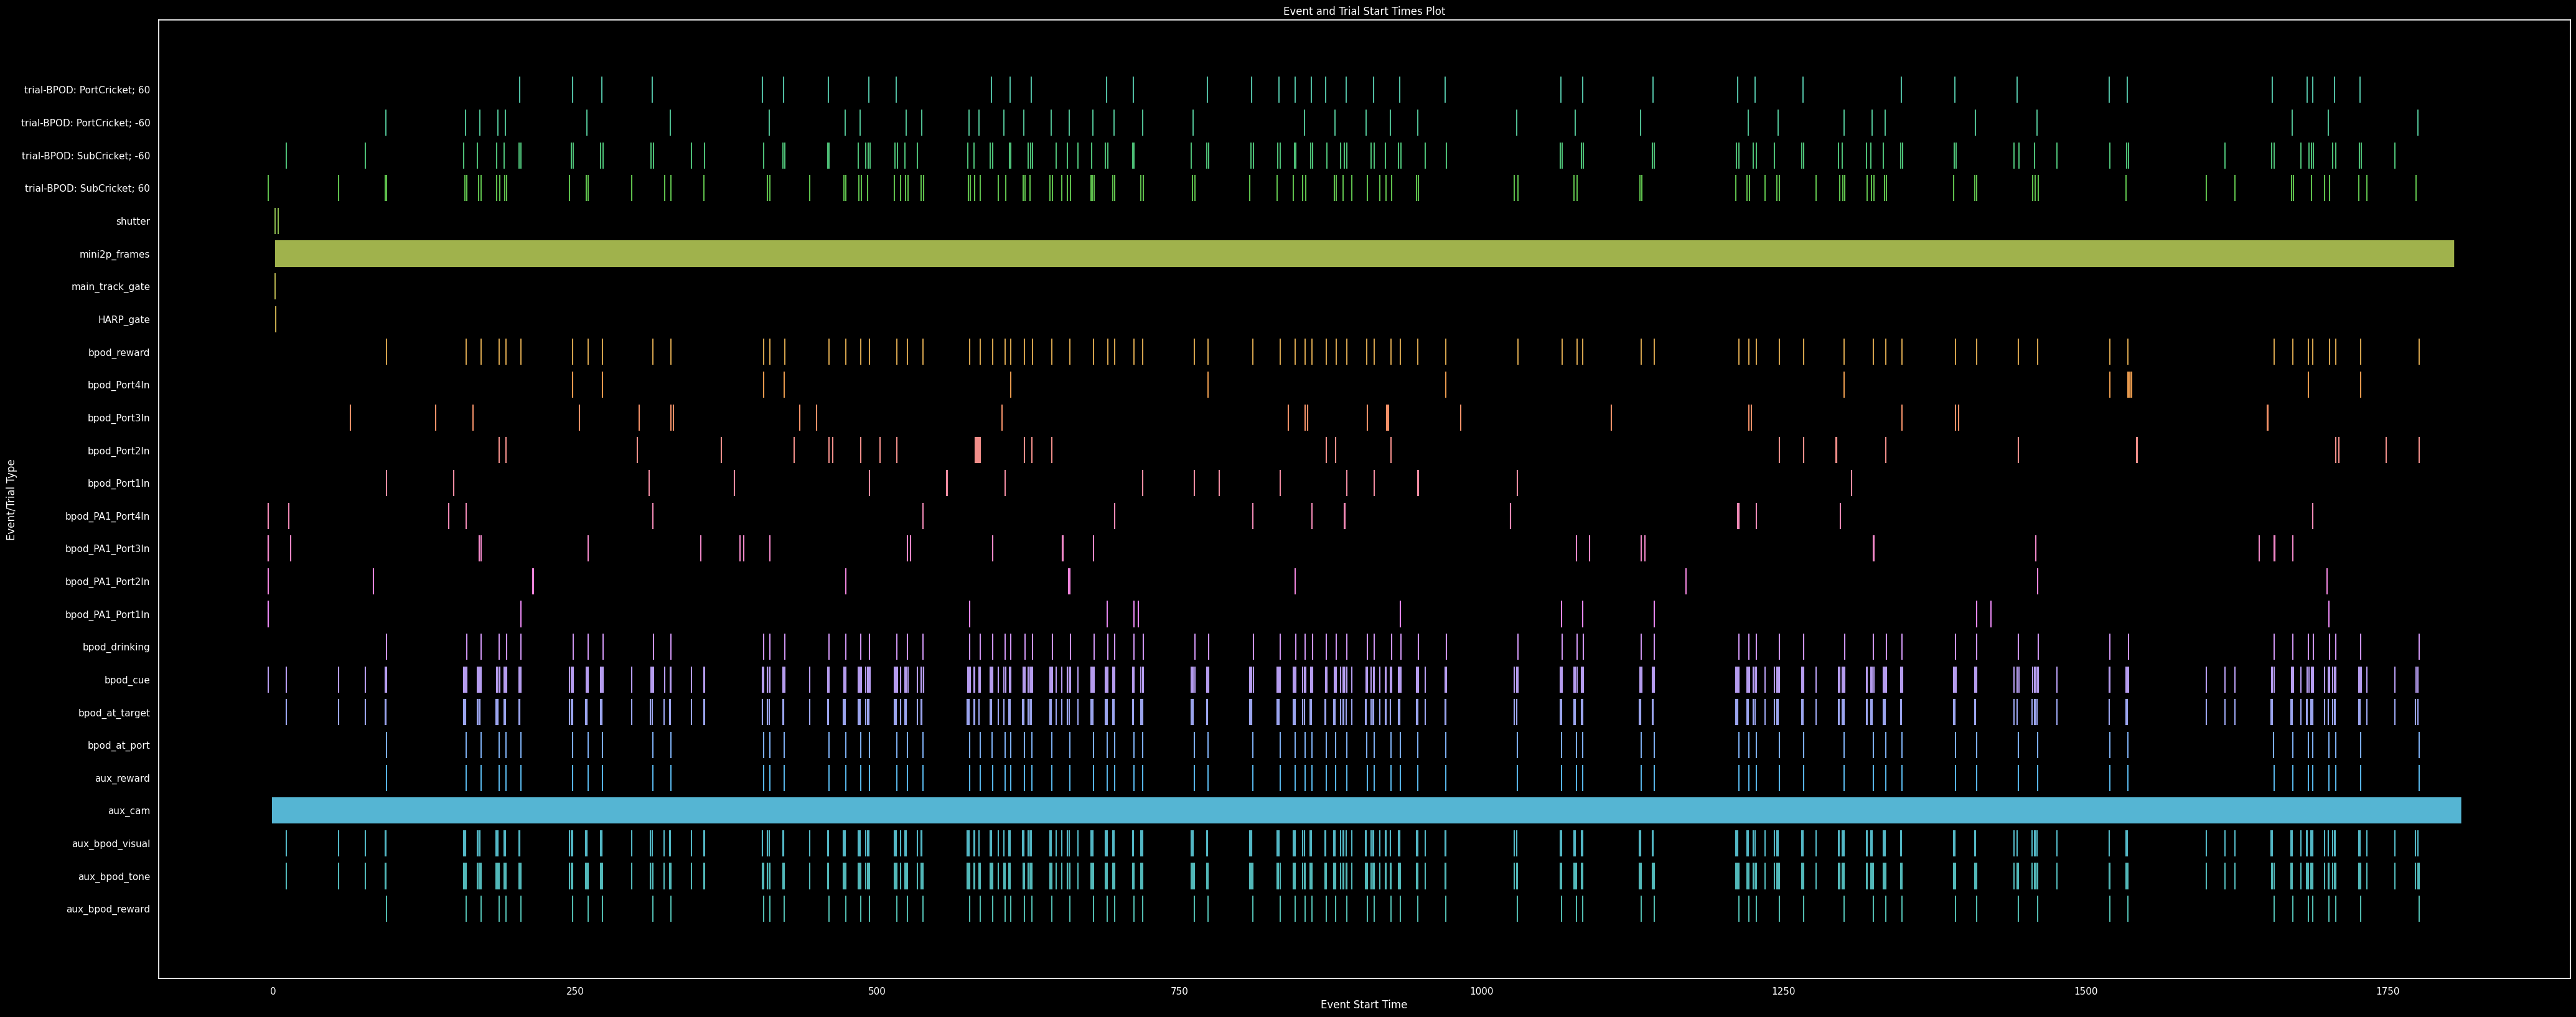

In [28]:
# Fetching data from the event.Event and trial.Trial tables
event_data = (event.Event & scan_key).fetch('event_type', 'event_start_time', as_dict=True)
trial_data = (trial.Trial & scan_key).fetch('trial_id', 'trial_type', 'trial_start_time', as_dict=True)

djh.plot_event_trial_start_times(event_data, trial_data)

### get BPOD object to play around

In [29]:
from adamacs.paths import get_imaging_root_data_dir, get_experiment_root_data_dir
from adamacs.ingest import bpod
from element_interface.utils import find_full_path

scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
bpod_path_relative = (scan.ScanPath & scan_key).fetch("path")[0]

bpod_path_full = list(find_full_path(
        get_experiment_root_data_dir(), bpod_path_relative
        ).glob("*mat"))[0]

print(bpod_path_full)

/datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y/scan9FKNRW9Y_ROS-1629_StimArenaVirtualCricketHunt_20231019_104324.mat


In [30]:
bpod_object = bpod.Bpodfile(bpod_path_full)

In [31]:
bpod_object.session_data["Info"]

{'StateMachineVersion': 'Bpod r2+',
 'Firmware': {'StateMachine': 23,
  'StateMachine_Minor': 10,
  'HiFi1': 4,
  'PA1': 2},
 'CircuitRevision': {'StateMachine': 1, 'HiFi1': 0, 'PA1': nan},
 'Modules': {'nModules': 3,
  'RelayActive': array([0, 0, 0], dtype=uint8),
  'Connected': array([1, 1, 0], dtype=uint8),
  'Name': array(['HiFi1', 'PA1', 'Serial3'], dtype=object),
  'Module2SM_BaudRate': array([1312500, 1312500, 1312500], dtype=int32),
  'FirmwareVersion': array([4, 2, 0], dtype=uint8),
  'nSerialEvents': array([20, 15, 10], dtype=uint8),
  'EventNames': array([array([], dtype=float64),
         array(['Port1In', 'Port1Out', 'Port2In', 'Port2Out', 'Port3In',
                'Port3Out', 'Port4In', 'Port4Out'], dtype=object)       ,
         array([], dtype=float64)], dtype=object),
  'USBport': array(['COM7', 'COM5', array([], dtype=float64)], dtype=object),
  'HWVersion_Major': array([ 1., nan, nan]),
  'HWVersion_Minor': array([ 0., nan, nan])},
 'SessionDate': '19-Oct-2023',
 'S

In [32]:
bpod_object.session_data["MousePos"]['PreStimDLC_live'][10]['right_ear']

{'X': 105.775345, 'Y': 74.7036, 'confidence': 0.99973613}

In [33]:
bpod_object.session_data['RawEvents']['Trial'][4]['States']

{'WaitForPosTriggerSoftCode': array([0.   , 0.615]),
 'CueDelayTrialCricket': array([0.615, 0.625]),
 'WaitForResponseCricket': array([0.625 , 0.6251]),
 'CueDelay': array([nan, nan]),
 'WaitForResponse': array([nan, nan]),
 'Port1RewardDelay': array([nan, nan]),
 'Port2RewardDelay': array([nan, nan]),
 'Port3RewardDelay': array([nan, nan]),
 'Port4RewardDelay': array([nan, nan]),
 'PA1_Port1RewardDelay': array([nan, nan]),
 'PA1_Port2RewardDelay': array([nan, nan]),
 'PA1_Port3RewardDelay': array([nan, nan]),
 'PA1_Port4RewardDelay': array([nan, nan]),
 'Port1Reward': array([nan, nan]),
 'Port2Reward': array([nan, nan]),
 'Port3Reward': array([nan, nan]),
 'Port4Reward': array([nan, nan]),
 'PA1_Port1Reward': array([nan, nan]),
 'PA1_Port2Reward': array([nan, nan]),
 'PA1_Port3Reward': array([nan, nan]),
 'PA1_Port4Reward': array([nan, nan]),
 'CloseValves': array([nan, nan]),
 'Drinking': array([nan, nan]),
 'Punish': array([nan, nan]),
 'EarlyWithdrawal': array([nan, nan])}

In [34]:
bpod_object.trial_data[4]['States']

{'WaitForPosTriggerSoftCode': array([0.   , 0.615]),
 'CueDelayTrialCricket': array([0.615, 0.625]),
 'WaitForResponseCricket': array([0.625 , 0.6251]),
 'CueDelay': array([nan, nan]),
 'WaitForResponse': array([nan, nan]),
 'Port1RewardDelay': array([nan, nan]),
 'Port2RewardDelay': array([nan, nan]),
 'Port3RewardDelay': array([nan, nan]),
 'Port4RewardDelay': array([nan, nan]),
 'PA1_Port1RewardDelay': array([nan, nan]),
 'PA1_Port2RewardDelay': array([nan, nan]),
 'PA1_Port3RewardDelay': array([nan, nan]),
 'PA1_Port4RewardDelay': array([nan, nan]),
 'Port1Reward': array([nan, nan]),
 'Port2Reward': array([nan, nan]),
 'Port3Reward': array([nan, nan]),
 'Port4Reward': array([nan, nan]),
 'PA1_Port1Reward': array([nan, nan]),
 'PA1_Port2Reward': array([nan, nan]),
 'PA1_Port3Reward': array([nan, nan]),
 'PA1_Port4Reward': array([nan, nan]),
 'CloseValves': array([nan, nan]),
 'Drinking': array([nan, nan]),
 'Punish': array([nan, nan]),
 'EarlyWithdrawal': array([nan, nan])}

In [35]:
bpod_object.trial_data[3]['Events']

{'PA1_Port2In': 6.7111,
 'PA1_Port2Out': 7.6726,
 'SoftCode15': 16.2092,
 'Tup': array([16.2192, 16.2193]),
 'HiFi1_1': 16.2193}

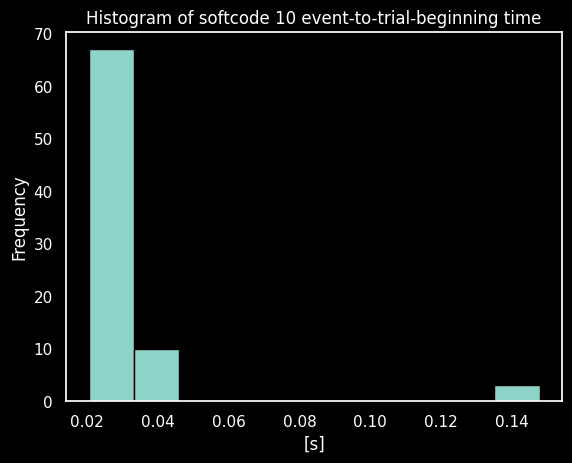

In [36]:
trials = bpod_object.trial_data
SoftCode10_events = [(i, trial['Events'].get('SoftCode10')) for i, trial in enumerate(trials) if 'SoftCode10' in trial['Events']] # get all trials that have a BNC1Low event. Returns a list of tuples (trial number, event time)

SoftCode10_events_times = [x[1] for x in SoftCode10_events]

plt.hist(SoftCode10_events_times, edgecolor='black')

plt.title('Histogram of softcode 10 event-to-trial-beginning time')
plt.xlabel('[s]')
plt.ylabel('Frequency')
# plt.xlim([0, 1])
plt.show()

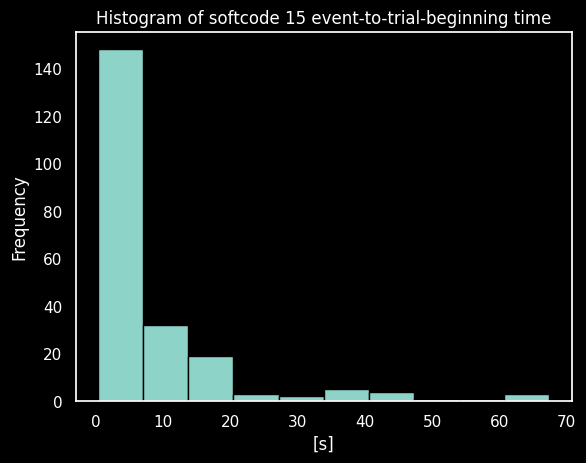

In [37]:
trials = bpod_object.trial_data
SoftCode15_events = [(i, trial['Events'].get('SoftCode15')) for i, trial in enumerate(trials) if 'SoftCode15' in trial['Events']] # get all trials that have a BNC1Low event. Returns a list of tuples (trial number, event time)

SoftCode15_events_times = [x[1] for x in SoftCode15_events]

plt.hist(SoftCode15_events_times, edgecolor='black')

plt.title('Histogram of softcode 15 event-to-trial-beginning time')
plt.xlabel('[s]')
plt.ylabel('Frequency')
# plt.xlim([0, 100])
plt.show()

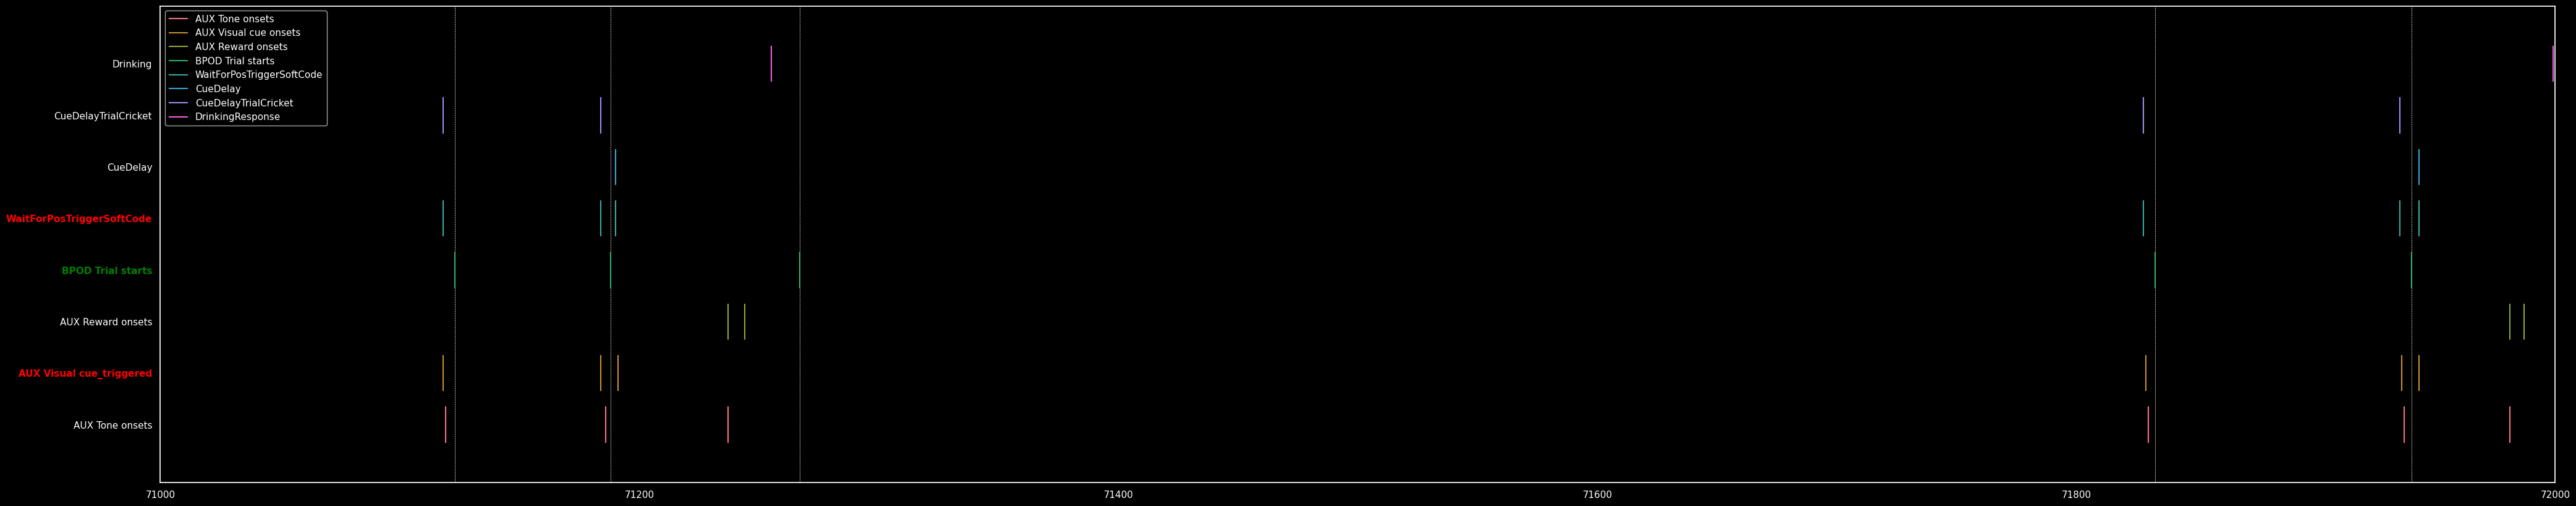

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Fetch trial data
trials = bpod_object.trial_data

# Fetch trial start timestamps
bpod_trial = bpod_object.session_data["TrialStartTimestamp"]

WaitForPosTriggerSoftCode_events = [(trial['States'].get('WaitForPosTriggerSoftCode') if trial['States'].get('WaitForPosTriggerSoftCode') is not None else 0) + bpod_trial[i] for i, trial in enumerate(trials) if 'WaitForPosTriggerSoftCode' in trial['States']]
WaitForPosTriggerSoftCode = [event[1] for event in WaitForPosTriggerSoftCode_events]

CueDelayTrialCricket_events = [(trial['States'].get('CueDelayTrialCricket') if trial['States'].get('CueDelayTrialCricket') is not None else 0) + bpod_trial[i] for i, trial in enumerate(trials) if 'CueDelayTrialCricket' in trial['States']]
CueDelayTrialCricket = [event[0] for event in CueDelayTrialCricket_events]

CueDelay_events = [(trial['States'].get('CueDelay') if trial['States'].get('CueDelay') is not None else 0) + bpod_trial[i] for i, trial in enumerate(trials) if 'CueDelay' in trial['States']]
CueDelay  = [event[0] for event in CueDelay_events]

Drinking_events = [(trial['States'].get('Drinking') if trial['States'].get('Drinking') is not None else 0) + bpod_trial[i] for i, trial in enumerate(trials) if 'Drinking' in trial['States']]
DrinkingResponse = [event[0] for event in Drinking_events]


# Fetch all trials that have a BNC1Low event. Returns a list of tuples (trial number, event time)
BNC1Low_events = [(i, trial['Events'].get('BNC1Low')) for i, trial in enumerate(trials) if 'BNC1Low' in trial['Events']]

# Fetch shutter event start times
AUX_shutter = (event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%shutter%"').fetch("event_start_time")

# Fetch event start times for visual and tone events
aux_vis = (event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%vis%"').fetch("event_start_time") 
aux_tone = (event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%tone%"').fetch("event_start_time") 
aux_reward = (event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%reward%"').fetch("event_start_time") 

# Adjust bpod_trial times

# bpodoffset = (BNC1Low_events[0][1]  + bpod_trial[0]) 

bpodoffset = (WaitForPosTriggerSoftCode[0]) 
aux_offset = aux_vis[0] 

WaitForPosTriggerSoftCode = WaitForPosTriggerSoftCode - bpodoffset + aux_offset
CueDelay = CueDelay - bpodoffset + aux_offset 
CueDelayTrialCricket = CueDelayTrialCricket - bpodoffset + aux_offset
DrinkingResponse = DrinkingResponse - bpodoffset + aux_offset
bpod_trial = bpod_trial - bpodoffset + aux_offset

# # Adjust AUX times
# aux_offset = aux_vis[0] 

# AUX_shutter = AUX_shutter - aux_offset #+  bpod_trial[1]
# aux_vis = aux_vis - aux_offset #+  bpod_trial[1]
# aux_tone    = aux_tone - aux_offset #+  bpod_trial[1]
# aux_reward = aux_reward - aux_offset #+  bpod_trial[1]


# Convert aux_tone, bpod_trial, and aux_vis values from seconds to deciseconds
tone_timestamps = (aux_tone * 100).astype(int)
trial_timestamps = (bpod_trial * 100).astype(int)
vis_timestamps = (aux_vis * 100).astype(int)
reward_timestamps = (aux_reward * 100).astype(int)
WaitForPosTriggerSoftCode_timestamps = (np.array(WaitForPosTriggerSoftCode) * 100).astype(int)
CueDelay_timestamps = (np.array(CueDelay) * 100).astype(int)
CueDelayTrialCricket_timestamps = (np.array(CueDelayTrialCricket) * 100).astype(int)
DrinkingResponse_timestamps = (np.array(DrinkingResponse) * 100).astype(int)

# Create separate timebases for each event type
timebase_tone = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_trial = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_vis = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_reward = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_WaitForPosTriggerSoftCode = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_CueDelay = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_CueDelayTrialCricket = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
DrinkResponse = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))


# Set the timebase samples that correspond to the tone onsets, trial starts, and visual cue onsets to one
# Each event has a duration of 100ms
for timestamp in tone_timestamps:
    timebase_tone[timestamp:timestamp+1] = 2
for timestamp in trial_timestamps:
    timebase_trial[timestamp:timestamp+1] = 3
for timestamp in vis_timestamps:
    timebase_vis[timestamp:timestamp+1] = 1
for timestamp in reward_timestamps:
    timebase_reward[timestamp:timestamp+1] = 4
for timestamp in WaitForPosTriggerSoftCode_timestamps:
    timebase_WaitForPosTriggerSoftCode[timestamp:timestamp+1] = 5
for timestamp in CueDelay_timestamps:
    timebase_CueDelay[timestamp:timestamp+1] = 6
for timestamp in CueDelayTrialCricket_timestamps:
    timebase_CueDelayTrialCricket[timestamp:timestamp+1] = 7  
for timestamp in DrinkingResponse_timestamps:
    DrinkResponse[timestamp:timestamp+1] = 8   

# Set the style to 'dark_background'
plt.style.use('dark_background')

# Create a color palette
colors = sns.color_palette("husl", 8)

# Create a figure with a width that fits the screen
plt.figure(figsize=(50, 10))

# Create tick plots with colors from the palette
linelength = 0.7

plt.eventplot(np.where(timebase_tone == 2)[0], lineoffsets=1, colors=colors[0], linelengths=linelength, label='AUX Tone onsets')
plt.eventplot(np.where(timebase_vis == 1)[0], lineoffsets=2, colors=colors[1], linelengths=linelength, label='AUX Visual cue onsets')
plt.eventplot(np.where(timebase_reward == 4)[0], lineoffsets=3, colors=colors[2], linelengths=linelength, label='AUX Reward onsets')
plt.eventplot(np.where(timebase_trial == 3)[0], lineoffsets=4, colors=colors[3], linelengths=linelength, label='BPOD Trial starts')
plt.eventplot(np.where(timebase_WaitForPosTriggerSoftCode == 5)[0], lineoffsets=5, colors=colors[4], linelengths=linelength, label='WaitForPosTriggerSoftCode')
plt.eventplot(np.where(timebase_CueDelay == 6)[0], lineoffsets=6, colors=colors[5], linelengths=linelength, label='CueDelay')
plt.eventplot(np.where(timebase_CueDelayTrialCricket == 7)[0], lineoffsets=7, colors=colors[6], linelengths=linelength, label='CueDelayTrialCricket') 
plt.eventplot(np.where(DrinkResponse == 8)[0], lineoffsets=8, colors=colors[7], linelengths=linelength, label='DrinkingResponse')

plt.yticks([1, 2, 3, 4, 5, 6, 7, 8], ['AUX Tone onsets', 'AUX Visual cue_triggered', 'AUX Reward onsets', 'BPOD Trial starts', 'WaitForPosTriggerSoftCode', 'CueDelay', 'CueDelayTrialCricket', 'Drinking'])

# Draw vertical lines where timebase_trial == 3

for i in np.where(timebase_trial == 3)[0]:
    plt.axvline(x=i, color='w', linestyle='--', linewidth=0.5, zorder=0)

# Get the y-tick labels
labels = plt.gca().get_yticklabels()

# Find the labels to change
for label in labels:
    if label.get_text() == 'WaitForPosTriggerSoftCode' or label.get_text() == 'AUX Visual cue_triggered':
        label.set_color('red')
        label.set_fontweight('bold')
    if label.get_text() == 'BPOD Trial starts':
        label.set_color('green')
        label.set_fontweight('bold')


plt.legend()
plt.xlim([71000, 72000])
plt.show()

## Run image processing jobs


In [ ]:
populate_settings = {'display_progress': True, 'suppress_errors': False, 'processes': 1}
imaging.Processing.populate(**populate_settings)

In [ ]:
dj.Diagram(imaging) + dj.Diagram(scan)

### Curation

In [ ]:
samesite = 'sess9FK61CPU'
key =  (session.SessionSameSite & f'same_site_id="{samesite}"').fetch('KEY')
# scan.Scan & key

In [ ]:

populate_settings = {'display_progress': True, 'suppress_errors': False, 'processes': 1}



### Creat a curation task for each entry in the imaging.Processing table

In [ ]:
for processing_task in imaging.ProcessingTask():
    # Extract necessary information from processing_task
    # This depends on the structure of your Processing table
    # For example, you might need the session_id and scan_id
    session_id = processing_task['session_id']
    scan_id = processing_task['scan_id']
    imaging.Curation().create1_from_processing_task({'session_id': session_id, 'scan_id': scan_id, "paramset_idx": 3, "manual_curation": False})


In [ ]:
### run trace populations

In [ ]:
selected_s2pparms_index = 3

# POPULATE!
populate_settings = {'display_progress': True, 'suppress_errors': False, 'processes': 1}

#imaging.Curation().create1_from_processing_task({'session_id': sessi, 'scan_id': scansi, "paramset_idx": selected_s2pparms_index, "manual_curation": 0})

imaging.MotionCorrection.populate(**populate_settings)

imaging.Segmentation.populate(**populate_settings)

imaging.MaskClassification.populate(**populate_settings)


In [ ]:

imaging.Fluorescence.populate(**populate_settings)


In [ ]:
imaging.Activity.populate(**populate_settings)

In [ ]:
print(imaging.Fluorescence.Trace.describe())

In [ ]:
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
curation_key = (imaging.Curation & scan_key & 'curation_id=1').fetch1('KEY')

## Make Movie

In [ ]:
path = (scan.ScanPath & curation_key).fetch1("path") + ("/suite2p/plane0/reg_tif")
sh.make_runninaverage_movie(path)

## Pose estimation

In [40]:
dj.Diagram(model) + dj.Diagram(equipment)

ValueError: Node names and attributes should not contain ":" unless they are quoted with "".                    For example the string 'attribute:data1' should be written as '"attribute:data1"'.                    Please refer https://github.com/pydot/pydot/issues/258

In [41]:
aux_setup_typestr = (scan.ScanInfo() & 'scan_id = "' + scansi + '"').fetch("userfunction_info")[0]
selected_DLCmodel = 'Topcam_2bin_without_scope'
print('- - - -')
print('DLC pose estimation:', scansi)

# insert TOP movie into model table
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4*"))[0])

key = {'session_id': scan_key["session_id"],
    'recording_id': scan_key["scan_id"], 
    'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
    }
model.VideoRecording.insert1(key, skip_duplicates=True)

key.update({'file_path': moviepath,
            'file_id': 0})  #INCREMENT FILE_ID WITH CAM NUMBER?

model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)
model.RecordingInfo.populate()

- - - -
DLC pose estimation: scan9FKNRW9Y


In [42]:

model.VideoRecording.File * model.VideoRecording() &  'recording_id = "' + scansi + '"'

session_id,recording_id,file_id,"file_path filepath of video, relative to root data directory",camera
sess9FKNRW9Y,scan9FKNRW9Y,0,/datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y/scan9FKNRW9Y_mini2p1_top_video_2023-10-19T10_44_15.mp4,mini2p1_top


In [43]:
key =  (model.VideoRecording & f'recording_id="{scansi}"').fetch1('KEY')
key.update({'model_name': selected_DLCmodel, 'task_mode': 'trigger'}) 
key      


{'session_id': 'sess9FKNRW9Y',
 'recording_id': 'scan9FKNRW9Y',
 'model_name': 'Topcam_2bin_without_scope',
 'task_mode': 'trigger'}

In [45]:
# INSERT pose estimation task
model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True, 'dynamic':(True,.5,60)}) # dynamic cropping

In [46]:
model.PoseEstimationTask() * model.VideoRecording * model.VideoRecording.File()

session_id,recording_id,model_name User-friendly model name,file_id,task_mode load results or trigger computation,pose_estimation_output_dir output dir relative to the root dir,"pose_estimation_params analyze_videos params, if not default",camera,"file_path filepath of video, relative to root data directory"
sess9FKNRW9Y,scan9FKNRW9Y,Topcam_2bin_without_scope,0,trigger,/datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y/device_mini2p1_top_recording_scan9FKNRW9Y_model_Topcam_2bin_without_scope,=BLOB=,mini2p1_top,/datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y/scan9FKNRW9Y_mini2p1_top_video_2023-10-19T10_44_15.mp4


In [47]:
model.RecordingInfo()

session_id,recording_id,px_height height in pixels,px_width width in pixels,nframes number of frames,fps (Hz) frames per second,recording_datetime Datetime for the start of the recording,recording_duration video duration (s) from nframes / fps
sess9FKNRW9Y,scan9FKNRW9Y,500,500,108268,60,None,1804.47


In [48]:
# run pose estimation
model.PoseEstimation.populate()

2023-12-04 15:22:35.010443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 15:22:35.256286: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tobiasr/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-12-04 15:22:35.256311: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-04 15:22:35.295476: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already 

Loading DLC 2.3.4...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)
Using snapshot-130000 for model /datajoint-data/models/tobiasr/NK_DLC_tracking/Topcam_2bin_wtscope-NK-2023-09-11/dlc-models/iteration-0/Topcam_2bin_wtscopeSep11-trainset95shuffle1
Starting analysis in dynamic cropping mode with parameters: (True, 0.5, 60)
Switching batchsize to 1, num_outputs (per animal) to 1 and TFGPUinference to False (all these features are not supported in this mode).


2023-12-04 15:22:39.932508: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tobiasr/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-12-04 15:22:39.932712: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-04 15:22:39.932731: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tatchu3): /proc/driver/nvidia/version does not exist
2023-12-04 15:22:39.933079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 15:22:39.963051: I t

Starting to analyze %  /datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y/scan9FKNRW9Y_mini2p1_top_video_2023-10-19T10_44_15.mp4
Loading  /datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y/scan9FKNRW9Y_mini2p1_top_video_2023-10-19T10_44_15.mp4
Duration of video [s]:  1804.47 , recorded with  60.0 fps!
Overall # of frames:  108268  found with (before cropping) frame dimensions:  500 500
Starting to extract posture


100%|█████████▉| 108200/108268 [45:08<00:01, 39.95it/s]


Saving results in /datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y/device_mini2p1_top_recording_scan9FKNRW9Y_model_Topcam_2bin_without_scope...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


#### make labeled video

In [49]:
from deeplabcut.utils.make_labeled_video import create_labeled_video
import yaml
from element_interface.utils import find_full_path
from adamacs.paths import get_dlc_root_data_dir


destfolder = model.PoseEstimationTask.infer_output_dir(key)
destfolder

video_path = find_full_path( # Fetch the full video path
    get_dlc_root_data_dir(), ((model.VideoRecording.File & key).fetch1("file_path"))
)

config_paths = sorted( # Of configs in the project path, defer to the datajoint-saved
    list(
        find_full_path(
            get_dlc_root_data_dir(), ((model.Model & key).fetch1("project_path"))
        ).glob("*.y*ml")
    )
)

create_labeled_video( # Pass strings to label the video
    config=str(config_paths[-1]),
    videos=str(video_path),
    destfolder=str(destfolder),
)

# list(list(pathlib.Path((model.VideoRecording.File & key).fetch1("file_path")).parent.glob("device*"))[0].glob("*.y*ml"))

Starting to process video: /datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y/scan9FKNRW9Y_mini2p1_top_video_2023-10-19T10_44_15.mp4
Loading /datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y/scan9FKNRW9Y_mini2p1_top_video_2023-10-19T10_44_15.mp4 and data.
Duration of video [s]: 1804.47, recorded with 60.0 fps!
Overall # of frames: 108268 with cropped frame dimensions: 500 500
Generating frames and creating video.


100%|██████████| 108268/108268 [04:32<00:00, 397.87it/s]


[True]

In [50]:
import glob
mp4_files = glob.glob(f"{destfolder}/*.mp4")
mp4_files[0]

'/datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y/device_mini2p1_top_recording_scan9FKNRW9Y_model_Topcam_2bin_without_scope/scan9FKNRW9Y_mini2p1_top_video_2023-10-19T10_44_15DLC_resnet50_Topcam_2bin_wtscopeSep11shuffle1_130000_labeled.mp4'

In [51]:
(model.PoseEstimation() * session.Session * session.SessionUser * subject.User()).fetch(format = "frame", order_by = "session_datetime")

,,,,pose_estimation_time,subject,session_datetime,name,shorthand,initials,email,lab
session_id,recording_id,model_name,user_id,,,,,,,,
sess9FKNRW9Y,scan9FKNRW9Y,Topcam_2bin_without_scope,3,2023-12-04 16:07:51,ROS-1629,2023-10-19,Krasilshchikova Natalia,nataliak,NK,nkra1@uni-bonn.de,Rose


In [52]:
# scansi = "scan9FKSMYYS"
scan_key = (model.PoseEstimation & f'recording_id = "{scansi}"').fetch('KEY')[0] 
path = (model.VideoRecording.File & scan_key).fetch("file_path")
path

array(['/datajoint-data/data/tobiasr/NK_ROS-1629_2023-10-19_scan9FKNRW9Y_sess9FKNRW9Y/scan9FKNRW9Y_mini2p1_top_video_2023-10-19T10_44_15.mp4'],
      dtype=object)

In [ ]:
(model.PoseEstimation.BodyPartPosition() & scan_key & 'body_part = "head_middle"').fetch("x_pos", "y_pos")

## Cleaning. Use with caution!

In [ ]:
imaging.ProcessingTask()

In [ ]:
scan_key

In [ ]:
# subject.Subject.delete()
# session.Session.delete()
# imaging.Processing.delete()
# imaging.Curation.delete()
# event.Event.delete()
# event.BehaviorRecording.delete()

In [ ]:
# key = (session.Session & "session_datetime >= '2023-10-01'").fetch('KEY')
# (session.Session & "session_datetime >= '2023-10-01'").delete()
# (imaging.ProcessingTask & "session_id LIKE 'sess9FKWT2RT%'").delete()
# (imaging.ProcessingTask  & key).delete()
# (model.PoseEstimationTask & key).delete()
(session.Session & "session_id LIKE '%sess9FK610VH%'").delete()
# (subject.Subject & "subject = 'ROS-1571'").delete()
# # subject.Subject.delete()
# # session.Session.delete()
# # imaging.Processing.delete()
# # imaging.Curation.delete()
# # event.Event.delete()
# # event.BehaviorRecording.delete()

In [ ]:
session.Session.delete()

In [ ]:
# session.Session.drop()
# scan.Scan.drop()
# imaging.Processing.drop()
# imaging.Curation.drop()

In [ ]:
# subject.Subject.drop()

In [ ]:
# imaging.Fluorescence.drop()

In [ ]:
imaging.Fluorescence.Trace.fetch(format = "frame")

In [ ]:
imaging.Fluorescence.NeuropilTrace.fetch(format = "frame")

In [ ]:
imaging.Fluorescence.Trace * 